<!-- Customize the font and markdown size -->
# Custom RL Algorithm with EVsSimulator gym environment
---

This Notebook provides a simple example of how to develop your own custom RL environment using the OpenAI Gym interface. We will use the **simple configuration of EVsSimulator** for the power *setpoint tracking problem*. We will then train a simple DQN agent to solve the environment.


### 1. Creating the Environment

- EVsSimulator simulates a Charge Point Operator (CPO) controlling a **fixed number of charging stations** scattered in a city where EVs that arrive and depart.

- The goal of the CPO is to **minimize the difference between the power setpoint and the actual power** consumed by the charging stations.

 - The CPO can control the current(**A**) of each port of each charging station. The current is limited by the **maximum current**(**I**) of the charging station and the **maximum current**(**I**) of the port.



Current directory: e:\GitHub\EVsSimulator\tutorials
Current directory: e:\GitHub\EVsSimulator
Initializing EVCity environment...
Creating directory: ./plots/ev_city_96_2024-01-13_12-53-49-869757


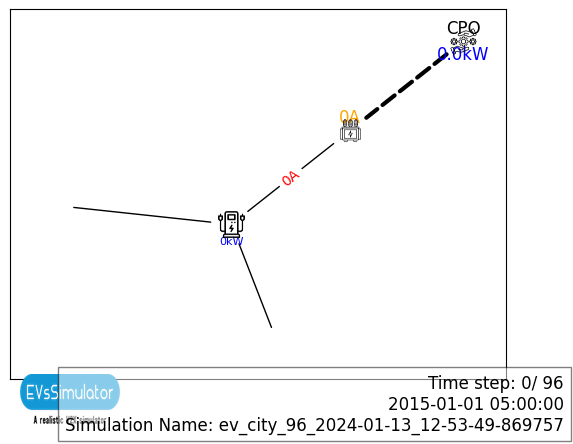

In [1]:
import sys
import os
import numpy as np
sys.path.append("..")
print("Current directory: " + os.getcwd())
#change directory   


os.chdir(os.getcwd() + "/..")
#print current_ directory
print("Current directory: " + os.getcwd())

from EVsSimulator import ev_city

# Create the environment
env = ev_city.EVCity(config_file="config_files/config_tutorial_1.yaml", render_mode=True)


#### 1.1 Action Space
The ***action space*** is a vector of size **N** (total number of ports) where each element is a continuous value between **-1** and **1** representing the **percentage of the maximum current** that the CPO wants to set for each 
port.

Values from -1 to 0 represent discharging the EVs, 0 means no current, and values from 0 to 1 represent charging the EVs.


**! For example**, in a case with a single charging station with 2 ports, the action space is a vector of size 2 (one for each port). In this case, [0,0] means neither port charges, [1,1] means both ports charge at the maximum current, [-1,-1] means both ports discharge at the maximum discharging current, [-0,5,0.7] means port 1 discharges at 50% of the maximum discharging current and port 2 charges at 70% of the maximum current.

In [7]:
# Get a random action
env.action_space.sample()

array([ 0.07756744, -0.52996577])

1.2 State Space

The ***state space*** provides information about the current state of the environment. Normaly the user has the option to configure the state space. In this case, the state space is a vector of size **N** (total number of ports) where each element is a continuous value between **-1** and **1** representing the **percentage of the maximum current** that the CPO wants to set for each port.

In [12]:
#Get a random state
env.observation_space.sample()

array([ 0.08916242,  0.90128285, -0.81067438, -0.45795571,  1.36834703,
       -2.83882402, -0.2987486 , -1.97934072,  0.57694699, -0.09935502,
        1.00255775, -2.10664814, -0.56815501])

In [68]:
env.step(np.array([0,0]),visualize=True)


 Step: 66 | 3 21:30: 0 | 	EVs +0 / -0 | Total: 0 / 2


(array([ 0.67708333,  0.42857143, -0.70710678,  0.70710678,  0.02074116,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ]),
 0.0,
 False,
 None)